# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



Business Understanding


In this notebook I want to understand how each demographic group across, gender, age group and income bracket react towards different offer type. I want to be able to analyse to understand each groups, build a model and share suggestions on what Starbucks could do moving forward. I have taken the below steps

1. Understanding the three datasets (Portfolio, profile, and transcript). This helps me see what I am working with, what I can do with the data and how I will need to clean the data in order to analyse it
2. Clean and Merge the data - This is were I am creating a dataset that I can use to analyse the data and also later used for the model
3. Exploratory Data Analysis (EDA) - now the data set it clean and merged I can really analyse the data and understand how the demographic groups are behaving towards the offer types
4. Build a model - this will help predict whether a customer is likely to complete an offer 

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


# read in the json files
portfolio = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/profile.json', orient='records', lines=True)
transcript = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/transcript.json', orient='records', lines=True)

Understanding & Analysing the three datasets



Analysising Portfolio Data

In [4]:
#print portfolio table 
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
#print portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [6]:
#print null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
#prnit description
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [8]:
# count offer types
print(portfolio['offer_type'].value_counts())  

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64


In [9]:
# Summary of duration and reward
print(portfolio[['duration', 'reward']].describe())  

        duration     reward
count  10.000000  10.000000
mean    6.500000   4.200000
std     2.321398   3.583915
min     3.000000   0.000000
25%     5.000000   2.000000
50%     7.000000   4.000000
75%     7.000000   5.000000
max    10.000000  10.000000


<Axes: title={'center': 'Offer Types Distribution'}, xlabel='offer_type'>

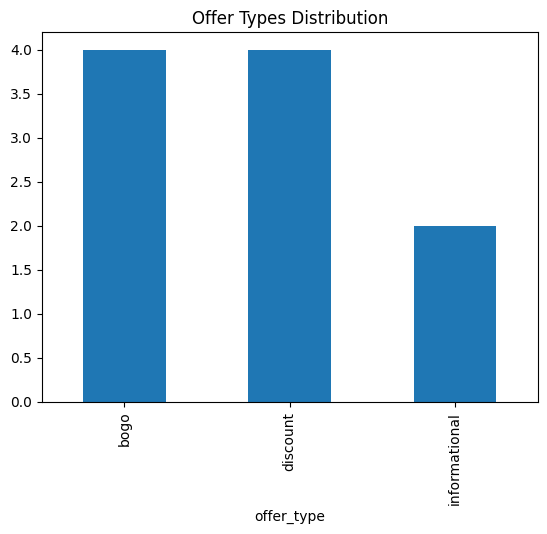

In [10]:
# Visualise offer types
portfolio['offer_type'].value_counts().plot(kind='bar', title='Offer Types Distribution')

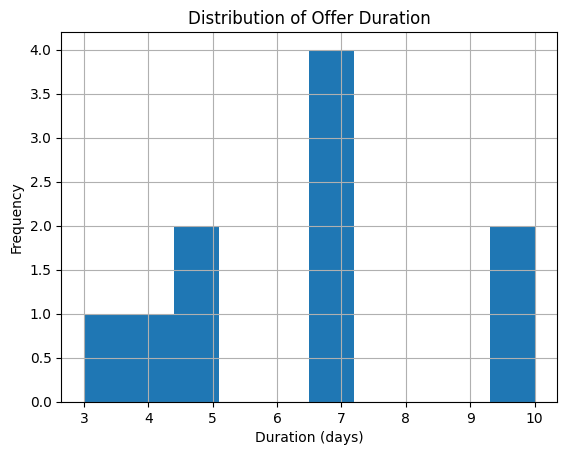

offer_type
bogo             6.0
discount         8.5
informational    3.5
Name: duration, dtype: float64


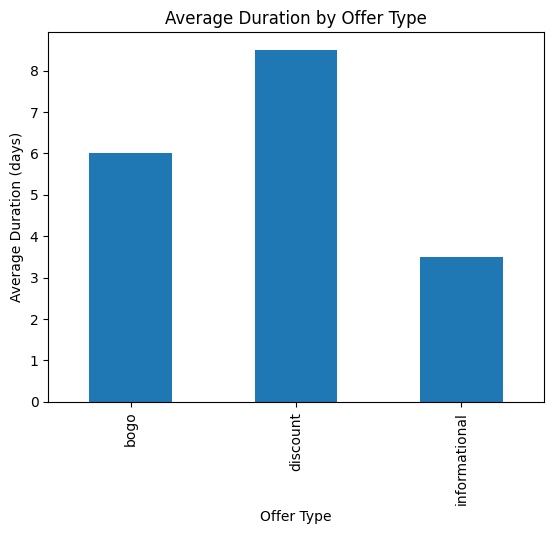

In [11]:
# Distribution of duration
portfolio['duration'].hist(bins=10)
plt.title('Distribution of Offer Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

# Average duration by offer type
duration_by_type = portfolio.groupby('offer_type')['duration'].mean()
print(duration_by_type)

# Visualise duration by offer type
duration_by_type.plot(kind='bar', title='Average Duration by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Average Duration (days)')
plt.show()

Counter({'email': 10, 'mobile': 9, 'web': 8, 'social': 6})


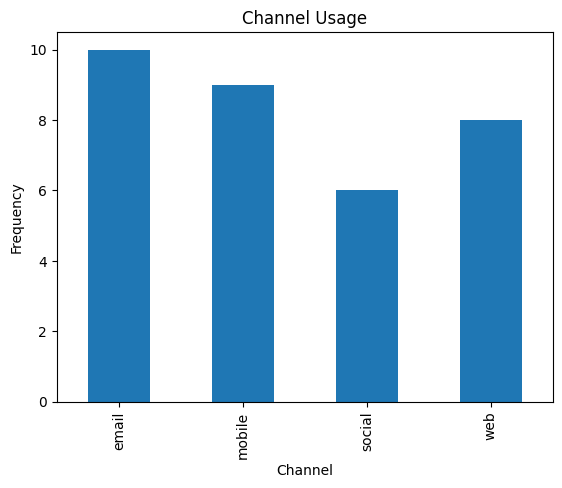

offer_type           
bogo           email     4
               mobile    4
               social    3
               web       3
discount       email     4
               mobile    3
               social    2
               web       4
informational  email     2
               mobile    2
               social    1
               web       1
Name: channels_str, dtype: int64


In [12]:
# Flatten the list of channels
from collections import Counter
channels = Counter([channel for sublist in portfolio['channels'] for channel in sublist])
print(channels)

# Visualise channel usage
pd.Series(channels).plot(kind='bar', title='Channel Usage')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.show()

# Analyse channels by offer type
portfolio['channels_str'] = portfolio['channels'].apply(lambda x: ', '.join(x))  # Convert list to string for grouping
channels_by_type = portfolio.groupby('offer_type')['channels_str'].apply(lambda x: Counter([channel for sublist in x.str.split(', ') for channel in sublist]))
print(channels_by_type)

In [13]:
portfolio.shape

(10, 7)

Summary of Portfolio Insights 

From my analysis of the porfolio dataset, i can see that The data has no null values which means the cleaning process is easier. we have a mix of data types and the dataset isn't large. BOGO and Dicount offers are more common than informational offers. The duration of Dicount offers is highest on average. Channel used is most likely to be email or web.


Analysing profile data

In [14]:
#print profile table 
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
#print profile info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
#print null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
#print description
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The max age is 118 which is quite suprising. On average i wouldn't expect to see ages above 100, although this isn't an impossible situation

Understanding age

In [18]:

# Check for ages above 100
print(profile[profile['age'] > 100])  

      gender  age                                id  became_member_on  income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6       None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7       None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
...      ...  ...                               ...               ...     ...
16980   None  118  5c686d09ca4d475a8f750f2ba07e0440          20160901     NaN
16982   None  118  d9ca82f550ac4ee58b6299cf1e5c824a          20160415     NaN
16989   None  118  ca45ee1883624304bac1e4c8a114f045          20180305     NaN
16991   None  118  a9a20fa8b5504360beb4e7c8712f8306          20160116     NaN
16994   None  118  c02b10e8752c4d8e9b73f918558531f7          20151211     NaN

[2180 rows x 5 columns]


In [19]:
# Filter ages above 100
ages_above_100 = profile[profile['age'] > 100]

# Get the value counts of ages above 100
age_counts = ages_above_100['age'].value_counts().reset_index()

# Rename columns for clarity
age_counts.columns = ['Age', 'Count']

# Display the table
print(age_counts)

   Age  Count
0  118   2175
1  101      5


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
gender
M    8484
F    6129
O     212
Name: count, dtype: int64
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


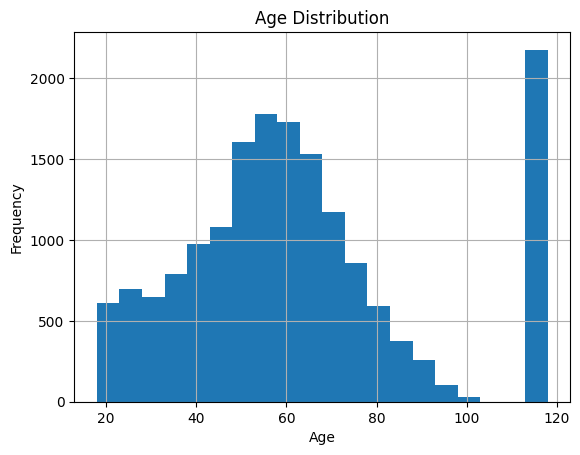

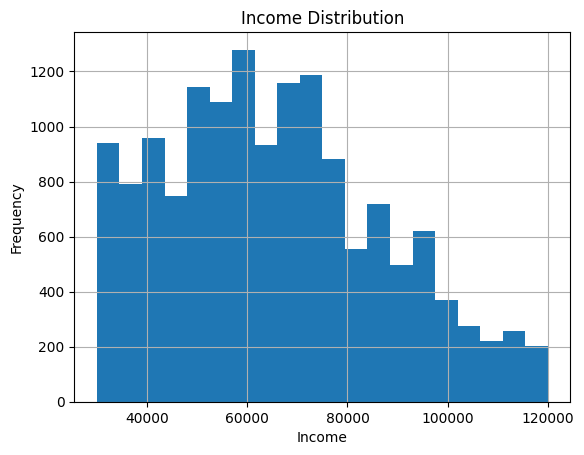

In [20]:
# Analyse profile
print(profile.isnull().sum())  # Check for missing values
print(profile['gender'].value_counts())  # Gender distribution
print(profile['age'].describe())  # Age statistics

# Visualise demographics
profile['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

profile['income'].hist(bins=20)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

There appears to be an anomly with customers listed as age 118. This value occurs with unusually high frequency then expected, particulary when compared to 101. Aditionally, the count for age 118 matches with the count of missing values for gender and income. As such, these records are likely invalid and may be best to remove from the dataset.

Analysing Profile data excluding age 118

In [21]:
# Filter rows where age is 118
age_118_rows = profile[profile['age'] == 118]

# Check missing values in gender and income for these rows
print(age_118_rows[['gender', 'income']].isnull().sum())

gender    2175
income    2175
dtype: int64


In [22]:
# Create a new dataset without rows where age is 118
profile_cleaned = profile[profile['age'] != 118]

# Verify the rows are removed in the new dataset
print(profile_cleaned['age'].value_counts().get(118, 0))  

# The original 'profile' dataset remains unchanged
print(profile['age'].value_counts().get(118, 0))  

0
2175


gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64
gender
M    8484
F    6129
O     212
Name: count, dtype: int64
count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


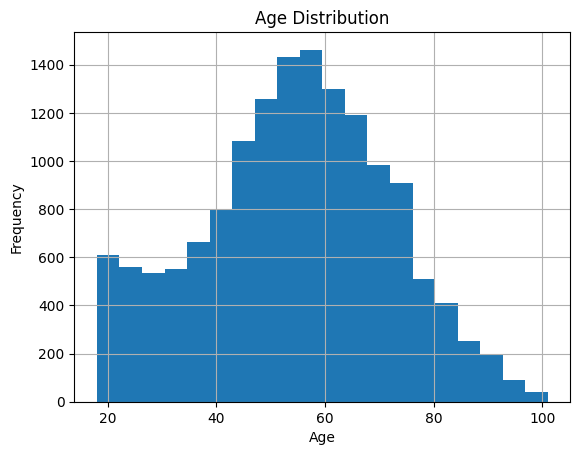

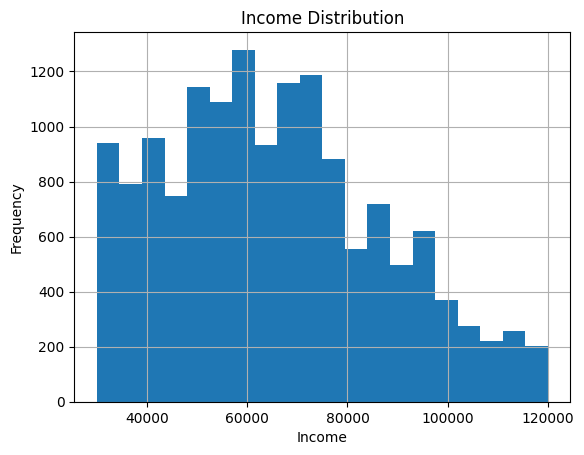

In [23]:
# Analyse profile
print(profile_cleaned.isnull().sum())  # Check for missing values
print(profile_cleaned['gender'].value_counts())  # Gender distribution
print(profile_cleaned['age'].describe())  # Age stats

# Visualise demographics
profile_cleaned['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

profile_cleaned['income'].hist(bins=20)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

age distribution seems way more realistic without age 118

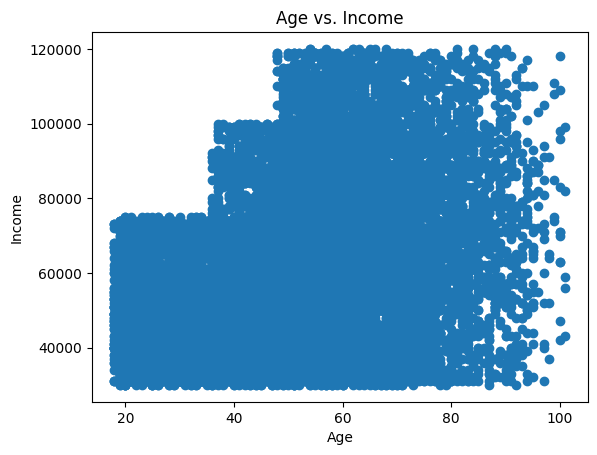

In [24]:
# Age vs. income scatter plot
plt.scatter(profile_cleaned['age'], profile_cleaned['income'])
plt.title('Age vs. Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()



Understanding Gender

gender
M    8484
F    6129
O     212
Name: count, dtype: int64


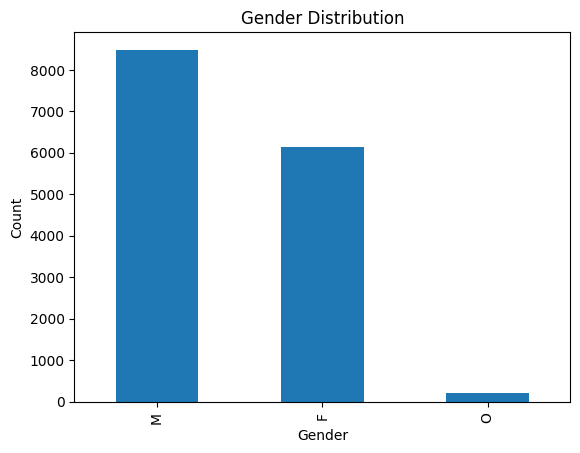

In [25]:
# Gender distribution
print(profile_cleaned['gender'].value_counts())

# Visualise gender distribution
profile_cleaned['gender'].value_counts().plot(kind='bar', title='Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

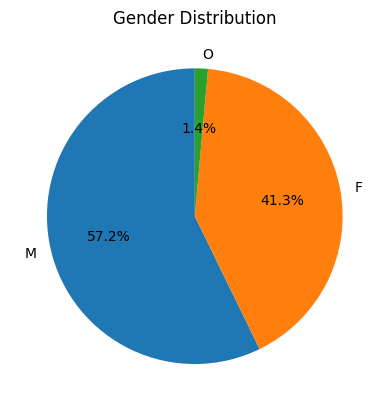

In [26]:
# Gender distribution pie chart
profile_cleaned['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, title='Gender Distribution')
plt.ylabel('')  # Remove y-axis label for better appearance
plt.show()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64


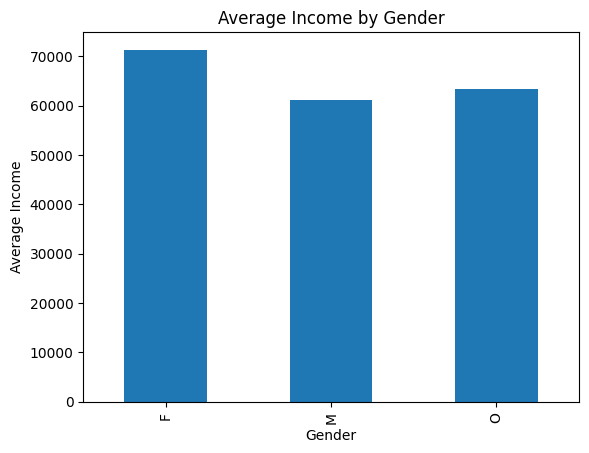

In [27]:
# Income by gender
income_by_gender = profile_cleaned.groupby('gender')['income'].mean()
print(income_by_gender)

# Visualise income by gender
income_by_gender.plot(kind='bar', title='Average Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Income')
plt.show()


In [28]:
# Convert 'became_member_on' to datetime format
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'].astype(str), format='%Y%m%d')

# Extract unique years from the 'became_member_on' column
unique_years = profile_cleaned['became_member_on'].dt.year.unique()

# Display the unique years
print(sorted(unique_years))

[np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018)]


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\2996059837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'].astype(str), format='%Y%m%d')


In [29]:
# Extract unique years from the 'became_member_on' column
unique_years = profile_cleaned['became_member_on'].dt.year.unique()

# Display the unique years
print(sorted(unique_years))

[np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018)]


In [30]:
# Ensure 'became_member_on' is a datetime column
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'])

# Group by gender and count membership start years
membership_by_gender = profile_cleaned.groupby('gender')['became_member_on'].apply(lambda x: x.dt.year.value_counts().sort_index())

# Display results
print(membership_by_gender)

gender  F   
F       2013      74
        2014     138
        2015     663
        2016    1509
        2017    2443
        2018    1302
M       2013     197
        2014     520
        2015     905
        2016    1483
        2017    3067
        2018    2312
O       2013       3
        2014       4
        2015      29
        2016      32
        2017      89
        2018      55
Name: became_member_on, dtype: int64


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\4157276988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'])


Understanding memberships

C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\3181380882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')


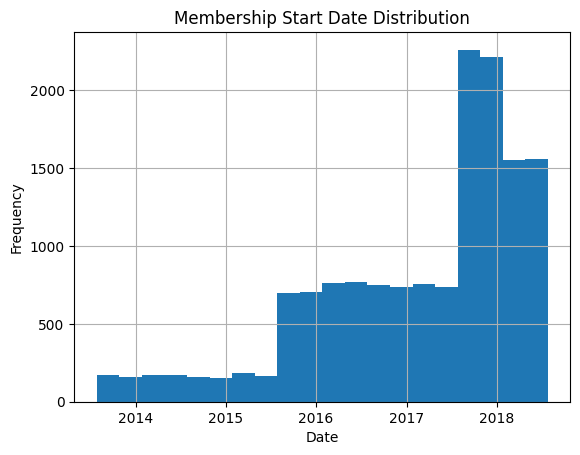

C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\3181380882.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['membership_year'] = profile_cleaned['became_member_on'].dt.year


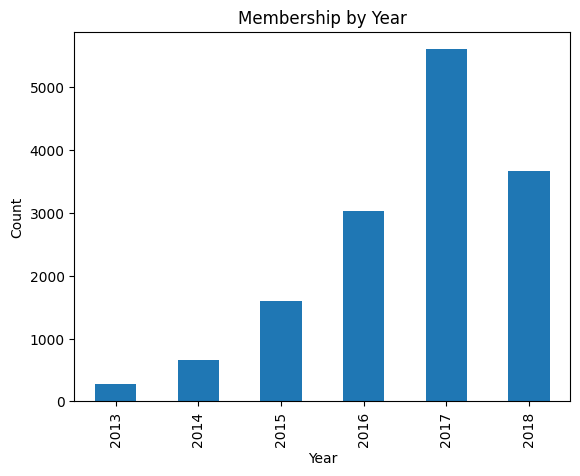

In [31]:
# Convert membership date to datetime
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')

# Plot membership start date distribution
profile_cleaned['became_member_on'].hist(bins=20)
plt.title('Membership Start Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

# Analyse membership by year
profile_cleaned['membership_year'] = profile_cleaned['became_member_on'].dt.year
profile_cleaned['membership_year'].value_counts().sort_index().plot(kind='bar', title='Membership by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [32]:
profile_cleaned.shape

(14825, 6)

C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\833897052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['membership_month'] = profile_cleaned['became_member_on'].dt.month


membership_month
1     1327
2     1042
3     1145
4     1145
5     1152
6     1105
7     1189
8     1395
9     1299
10    1386
11    1268
12    1372
Name: count, dtype: int64


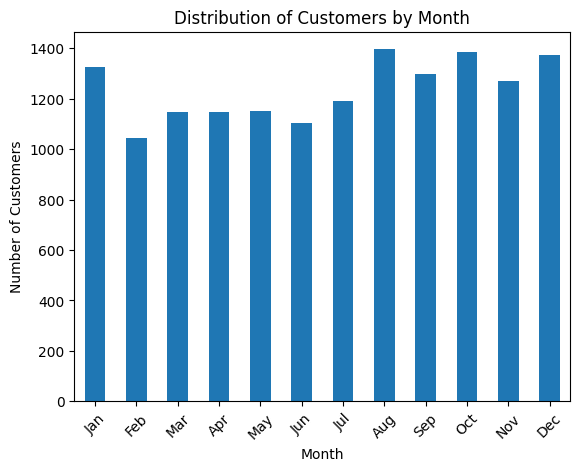

In [33]:
# Extract month from the membership date
profile_cleaned['membership_month'] = profile_cleaned['became_member_on'].dt.month

# Count the number of customers for each month
customers_by_month = profile_cleaned['membership_month'].value_counts().sort_index()

# Display the distribution
print(customers_by_month)

# Visualize the distribution
customers_by_month.plot(kind='bar', title='Distribution of Customers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Its interesting to see it high in august, although maybe because it is hot and summer holidays. Autumn and winter is when we see peaks. 

Summary of analysis of profile data

There seems to be an anomoly with age 118, which is why it looks best to exclude from analysis. With removing it, this now means that there are no null values in the dataset. Majority of customers are more middle aged to older with a mediann at 55. There looks to be more male the female customers. Most customers earn between $30,000 and $80,000. Most customers joined the app in the more recent years with a spike in 2017

Analysing Transcript Data

In [34]:
#print table
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [35]:
#print info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [36]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [37]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [38]:
transcript.shape

(306534, 4)

<Axes: title={'center': 'Event Types Distribution'}, xlabel='event'>

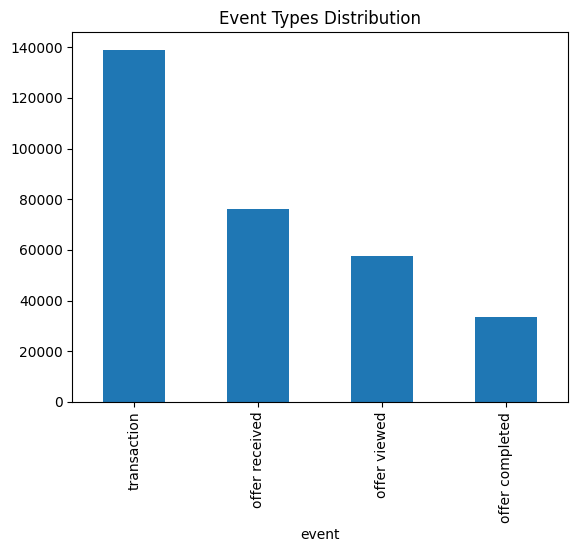

In [39]:
# Visualise event distribution
transcript['event'].value_counts().plot(kind='bar', title='Event Types Distribution')

Summary

The data has no null values. We can see the there are more transactions and it reduces for each event, with offer completed being the lowest.

Cleaning and Merging the datasets

In [40]:
def clean_profile(df):
    """Clean profile dataset and remove age 118 customers."""

    df = df[df['age'] != 118].copy()  # Remove customers with age 118
    
    # Rename columns
    df = df.rename(columns={
        'id': 'customer_id',
        'became_member_on': 'membership_date'
    })

    # Create age groups
    bins = [17, 25, 35, 45, 55, 65, 75, 85, 101]
    labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

    # Convert membership_date to datetime
    df['membership_date'] = pd.to_datetime(df['membership_date'].astype(str), format='%Y%m%d')

    return df

def clean_portfolio(df):
    """Clean portfolio dataset."""

    df = df.rename(columns={
        'id': 'offer_id',
        'duration': 'offer_duration',
        'difficulty': 'offer_difficulty',
        'reward': 'offer_reward',
        'channels': 'offer_channels'
    })

    # Convert channels list to string
    df['channels_str'] = df['offer_channels'].apply(lambda x: ', '.join(x))

    return df

def clean_transcript(df):
    """Clean transcript dataset and extract offer_id and amount."""

    df = df.rename(columns={'person': 'customer_id'})

    # Extract offer_id 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer id') if isinstance(x, dict) and 'offer id' in x else x.get('offer_id') if isinstance(x, dict) and 'offer_id' in x else None)

    # Extract amount from transactions
    df['amount'] = df['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) and 'amount' in x else None)

    df = df.drop(columns=['value'])

    return df

In [41]:
def merge_cleaned_data(portfolio_df, profile_df, transcript_df):
    
    """Merge cleaned datasets ensuring no age 118 customers are included."""
    
    # Get valid customer IDs (excluding age 118)
    valid_customers = set(profile_df['customer_id'])

    # Keep only valid customers in transcript
    transcript_df = transcript_df[transcript_df['customer_id'].isin(valid_customers)]

    # Merge transcript with portfolio (using outer join to keep all events)
    merged_df = transcript_df.merge(
        portfolio_df,
        on='offer_id',
        how='left'
    )

    # Merge with profile
    merged_df = merged_df.merge(
        profile_df,
        on='customer_id',
        how='inner'
    )

    return merged_df

In [42]:
# Clean the datasets
profile_cleaned = clean_profile(profile)
portfolio_cleaned = clean_portfolio(portfolio)
transcript_cleaned = clean_transcript(transcript)

# Merge the cleaned datasets
merged_df = merge_cleaned_data(portfolio_cleaned, profile_cleaned, transcript_cleaned)

# Verify that "offer completed" is still present
print("\nEvent Types After Merging:")
print(merged_df['event'].value_counts())

# Verify no age 118 customers remain
print("\nAge distribution in merged dataset:")
print(merged_df['age'].value_counts().sort_index())

# Check for null values
print("\nNull values in merged dataset:")
print(merged_df.isnull().sum())


Event Types After Merging:
event
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: count, dtype: int64

Age distribution in merged dataset:
age
18     1367
19     2595
20     2582
21     2762
22     2430
       ... 
97      239
98       85
99       99
100     234
101      98
Name: count, Length: 84, dtype: int64

Null values in merged dataset:
customer_id              0
event                    0
time                     0
offer_id            123957
amount              148805
offer_reward        123957
offer_channels      123957
offer_difficulty    123957
offer_duration      123957
offer_type          123957
channels_str        123957
gender                   0
age                      0
membership_date          0
income                   0
age_group                0
dtype: int64


In [43]:
portfolio_cleaned.shape, profile_cleaned.shape, transcript_cleaned.shape, merged_df.shape

((10, 7), (14825, 6), (306534, 5), (272762, 16))

In [44]:
merged_df

,customer_id,event,time,offer_id,amount,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,channels_str,gender,age,membership_date,income,age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,"web, email, mobile",F,75,2017-05-09,100000.0,66-75
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,"web, email, mobile",M,68,2018-04-26,70000.0,66-75
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,"web, email, mobile, social",M,65,2018-02-09,53000.0,56-65
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,"web, email, mobile",M,58,2017-11-11,51000.0,56-65
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,"[web, email]",20.0,10.0,discount,"web, email",F,61,2017-09-11,57000.0,56-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,"web, email, mobile, social",F,48,2017-12-28,80000.0,46-55
272758,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,NaN,NaN,NaN,NaN,NaN,NaN,M,66,2018-01-01,47000.0,66-75
272759,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,NaN,NaN,NaN,NaN,NaN,NaN,M,52,2018-04-08,62000.0,46-55
272760,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,NaN,NaN,NaN,NaN,NaN,NaN,F,63,2013-09-22,52000.0,56-65


In [45]:
# List of columns in merged_df
print(merged_df.columns.tolist())

['customer_id', 'event', 'time', 'offer_id', 'amount', 'offer_reward', 'offer_channels', 'offer_difficulty', 'offer_duration', 'offer_type', 'channels_str', 'gender', 'age', 'membership_date', 'income', 'age_group']


In [46]:
# One-hot encode the 'event' column
event_dummies = pd.get_dummies(merged_df['event'], prefix='event')

# Merge the new columns back into the dataframe
merged_df = pd.concat([merged_df, event_dummies], axis=1)

# Drop the original event column
merged_df.drop(columns=['event'], inplace=True)


In [47]:
merged_df.rename(columns={
    'event_offer received': 'offer_received',
    'event_offer viewed': 'offer_viewed',
    'event_offer completed': 'offer_completed',
    'event_transaction': 'transaction'
}, inplace=True)


In [48]:
# Filter only rows where an offer_id exists
offer_events_df = merged_df[merged_df['offer_id'].notna()].copy()


In [49]:
# groupby
offer_response = offer_events_df.groupby(
    ['customer_id', 'offer_id', 'offer_type']
).agg(
    received=('offer_received', 'max'),
    viewed=('offer_viewed', 'max'),
    completed=('offer_completed', 'max')
).reset_index()



In [50]:
#Create income bins
income_bins = [30000, 49000, 64000, 80000, 120001]
income_labels = ['Low', 'Mid-Low', 'Mid-High', 'High']

profile_cleaned['income_bracket'] = pd.cut(
    profile_cleaned['income'],
    bins=income_bins,
    labels=income_labels,
    right=True
)


In [51]:
# Merge offer_response with profile_cleaned
offer_response = offer_response.merge(
    profile_cleaned[['customer_id', 'gender', 'age_group', 'income_bracket']],
    on='customer_id',
    how='left'
)

In [52]:
#check columns
print(merged_df.columns)


Index(['customer_id', 'time', 'offer_id', 'amount', 'offer_reward',
       'offer_channels', 'offer_difficulty', 'offer_duration', 'offer_type',
       'channels_str', 'gender', 'age', 'membership_date', 'income',
       'age_group', 'offer_completed', 'offer_received', 'offer_viewed',
       'transaction'],
      dtype='object')


In [53]:
## Convert boolean event flags to integers
cols_to_fix = ['offer_received', 'offer_viewed', 'offer_completed', 'transaction']
merged_df[cols_to_fix] = merged_df[cols_to_fix].astype(int)


In [54]:
#print table
merged_df.head()

,customer_id,time,offer_id,amount,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,channels_str,gender,age,membership_date,income,age_group,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,"web, email, mobile",F,75,2017-05-09,100000.0,66-75,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,"web, email, mobile",M,68,2018-04-26,70000.0,66-75,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,"web, email, mobile, social",M,65,2018-02-09,53000.0,56-65,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,"web, email, mobile",M,58,2017-11-11,51000.0,56-65,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,"[web, email]",20.0,10.0,discount,"web, email",F,61,2017-09-11,57000.0,56-65,0,1,0,0


In [55]:
#print table
offer_response.head()


,customer_id,offer_id,offer_type,received,viewed,completed,gender,age_group,income_bracket
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,True,False,True,M,26-35,Mid-High
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,True,True,False,M,26-35,Mid-High
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,True,True,False,M,26-35,Mid-High
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,True,True,True,M,26-35,Mid-High
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,True,True,True,M,26-35,Mid-High


In [56]:
# Add a flag for offers that were both viewed AND completed
offer_response['viewed_and_completed'] = ((offer_response['viewed'] == 1) & (offer_response['completed'] == 1)).astype(int)


In [57]:
offer_response.head()

,customer_id,offer_id,offer_type,received,viewed,completed,gender,age_group,income_bracket,viewed_and_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,True,False,True,M,26-35,Mid-High,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,True,True,False,M,26-35,Mid-High,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,True,True,False,M,26-35,Mid-High,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,True,True,True,M,26-35,Mid-High,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,True,True,True,M,26-35,Mid-High,1


Exploratory Data Analysis (EDA)

In [58]:
#Response Rate by Offer Type
offer_response.groupby('offer_type')['completed'].mean()


offer_type
bogo             0.598314
discount         0.666486
informational    0.000000
Name: completed, dtype: float64

In [59]:
#Response Rate by Age Group and Offer Type
offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().unstack()


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\4064735465.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().unstack()


offer_type,bogo,discount,informational
age_group,,,
18-25,0.430371,0.542707,0.0
26-35,0.479903,0.563671,0.0
36-45,0.572250,0.638908,0.0
46-55,0.628357,0.686726,0.0
56-65,0.639144,0.697136,0.0
66-75,0.620870,0.697668,0.0
76-85,0.662291,0.721390,0.0
86+,0.659121,0.711978,0.0


In [60]:
#Response Rate by Age Group and Offer Type
offer_response.groupby(['age_group', 'offer_type'])['viewed'].mean().unstack()


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\3226384640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_response.groupby(['age_group', 'offer_type'])['viewed'].mean().unstack()


offer_type,bogo,discount,informational
age_group,,,
18-25,0.821618,0.609067,0.691293
26-35,0.823245,0.628063,0.653347
36-45,0.879526,0.736860,0.777931
46-55,0.851128,0.726483,0.756734
56-65,0.839464,0.737348,0.720016
66-75,0.845797,0.730492,0.719561
76-85,0.862172,0.718394,0.748858
86+,0.836218,0.711978,0.685422


In [61]:
#Response Rate by Gender and Offer Type
offer_response.groupby(['gender', 'offer_type'])['completed'].mean().unstack()


offer_type,bogo,discount,informational
gender,,,
F,0.709025,0.747420,0.0
M,0.516348,0.607272,0.0
O,0.699670,0.716172,0.0


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\2809666546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_completion = offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().reset_index()


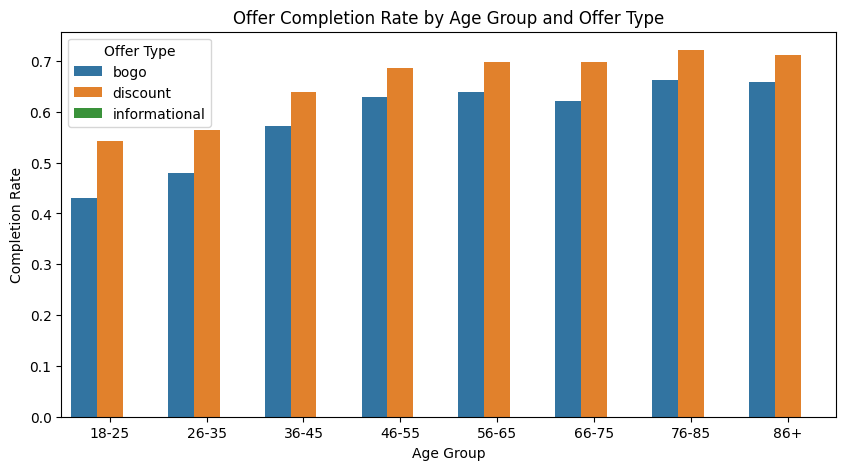

In [62]:
#Offer complettion Rate by age group and offer type
age_completion = offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().reset_index()

#Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=age_completion, x='age_group', y='completed', hue='offer_type')
plt.title('Offer Completion Rate by Age Group and Offer Type')
plt.ylabel('Completion Rate')
plt.xlabel('Age Group')
plt.legend(title='Offer Type')
plt.show()


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\2582879812.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_offer_completion = offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().unstack()


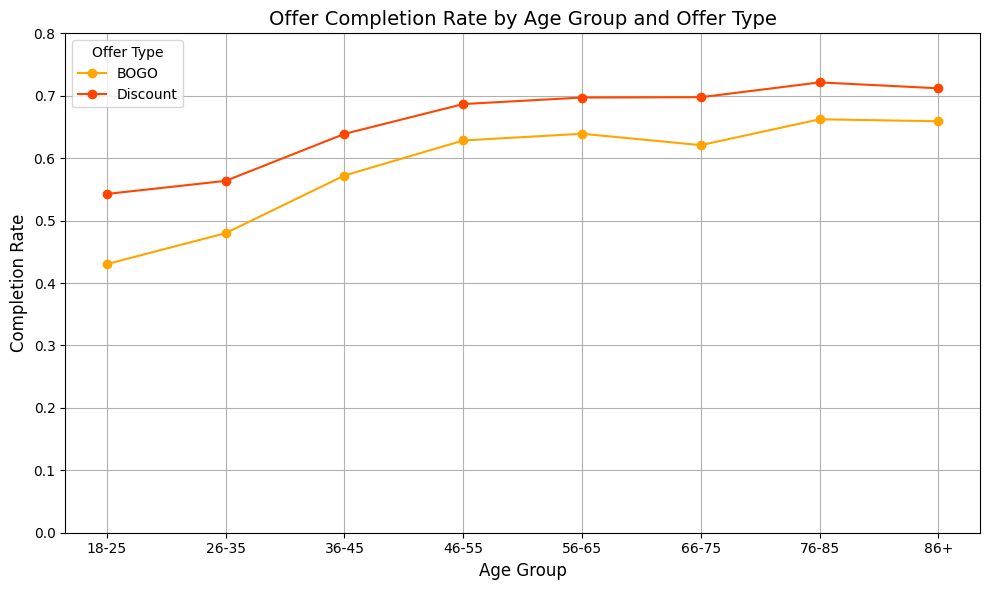

In [63]:
# Group by age group and offer type, calculate mean completion rate
age_offer_completion = offer_response.groupby(['age_group', 'offer_type'])['completed'].mean().unstack()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(age_offer_completion.index, age_offer_completion['bogo'], marker='o', label='BOGO', color='orange')
plt.plot(age_offer_completion.index, age_offer_completion['discount'], marker='o', label='Discount', color='orangered')

plt.title('Offer Completion Rate by Age Group and Offer Type', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Completion Rate', fontsize=12)
plt.ylim(0, 0.8)
plt.legend(title='Offer Type')
plt.grid(True)
plt.tight_layout()
plt.show()

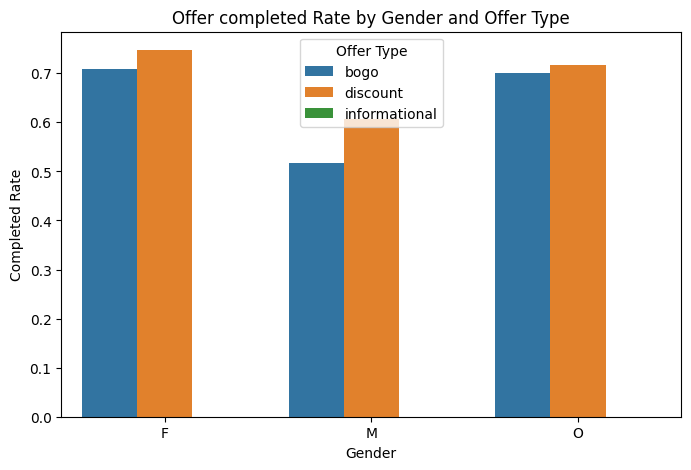

In [64]:
#offer completed rate by gender and offer type
gender_view = offer_response.groupby(['gender', 'offer_type'])['completed'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=gender_view, x='gender', y='completed', hue='offer_type')
plt.title('Offer completed Rate by Gender and Offer Type')
plt.ylabel('Completed Rate')
plt.xlabel('Gender')
plt.legend(title='Offer Type')
plt.show()

C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\1131173584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_view = offer_response.groupby(['income_bracket', 'offer_type'])['completed'].mean().reset_index()


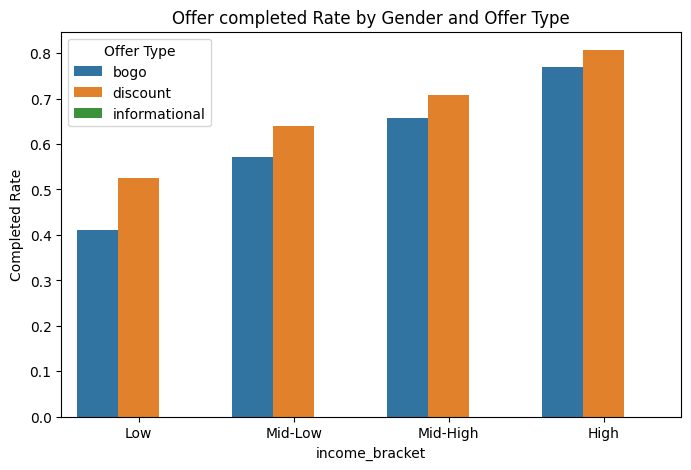

In [65]:
#offer completed rate by income bracket and offer type
gender_view = offer_response.groupby(['income_bracket', 'offer_type'])['completed'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=gender_view, x='income_bracket', y='completed', hue='offer_type')
plt.title('Offer completed Rate by Gender and Offer Type')
plt.ylabel('Completed Rate')
plt.xlabel('income_bracket')
plt.legend(title='Offer Type')
plt.show()

In [66]:
# Average response rates per age group and offer_type
age_event_plot = offer_response.groupby(['age_group', 'offer_type'])[
    ['received', 'viewed', 'completed', 'viewed_and_completed']
].mean().reset_index()



C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\633842893.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_event_plot = offer_response.groupby(['age_group', 'offer_type'])[


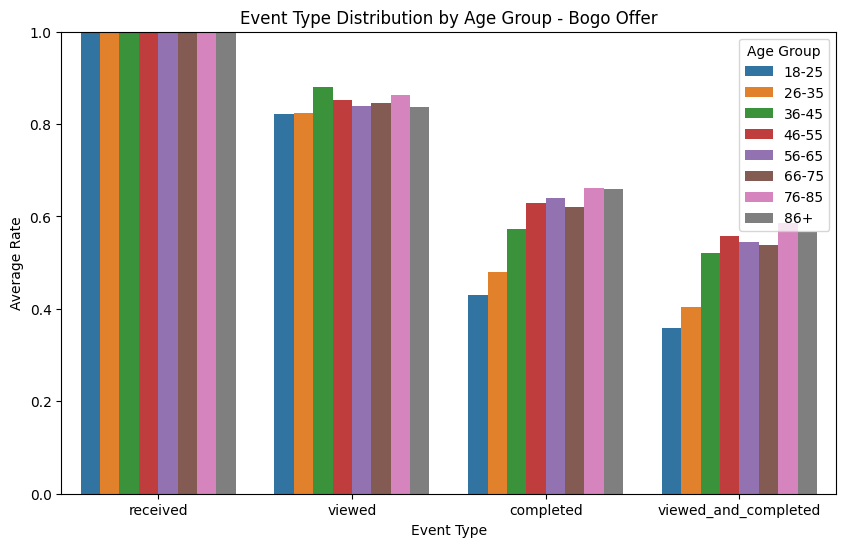

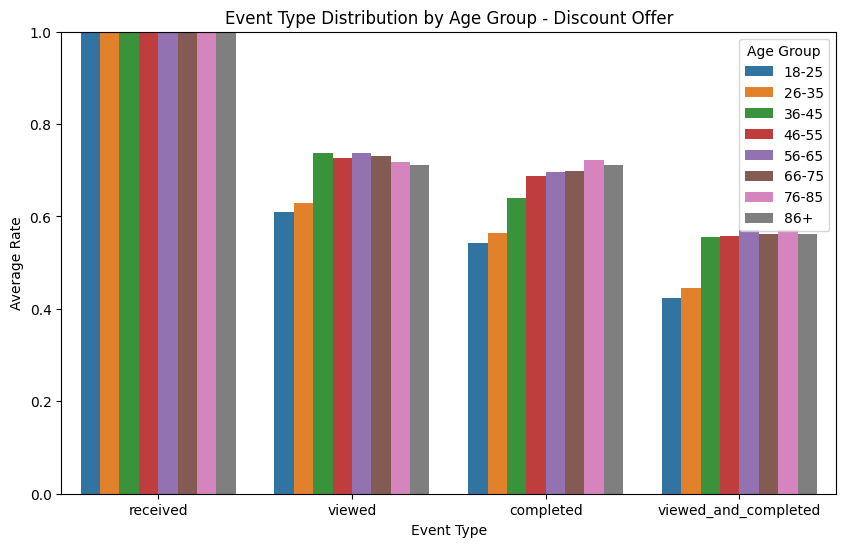

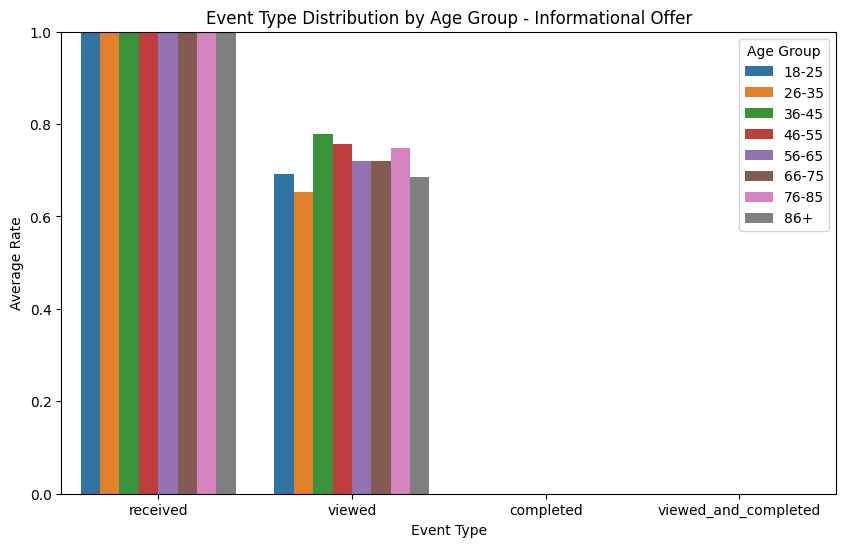

In [67]:
# Loop through each offer type
for offer in age_event_plot['offer_type'].unique():
    subset = age_event_plot[age_event_plot['offer_type'] == offer]

    # Reformat so 'event type' is on x-axis
    plot_df = pd.melt(
        subset,
        id_vars='age_group',
        value_vars=['received', 'viewed', 'completed', 'viewed_and_completed'],
        var_name='event_type',
        value_name='rate'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='event_type', y='rate', hue='age_group')
    plt.title(f'Event Type Distribution by Age Group - {offer.capitalize()} Offer')
    plt.ylabel('Average Rate')
    plt.xlabel('Event Type')
    plt.ylim(0, 1)
    plt.legend(title='Age Group')
    plt.show()

In [68]:
# Average response rates per gender and offer_type
gender_event_plot = offer_response.groupby(['gender', 'offer_type'])[
    ['received', 'viewed', 'completed', 'viewed_and_completed']
].mean().reset_index()


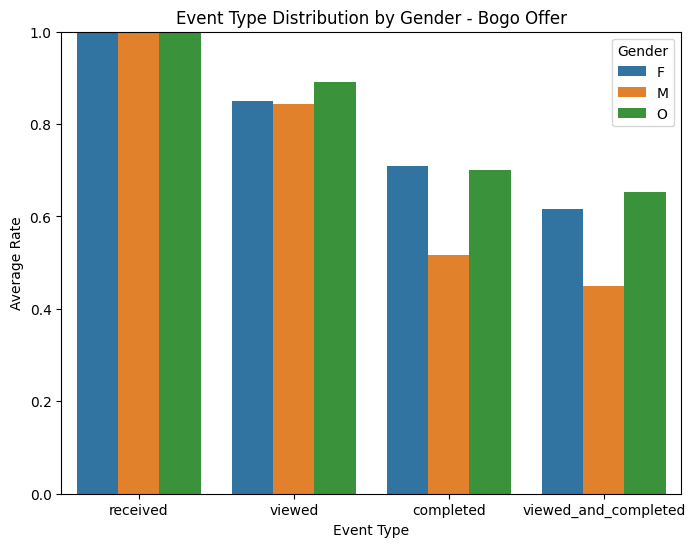

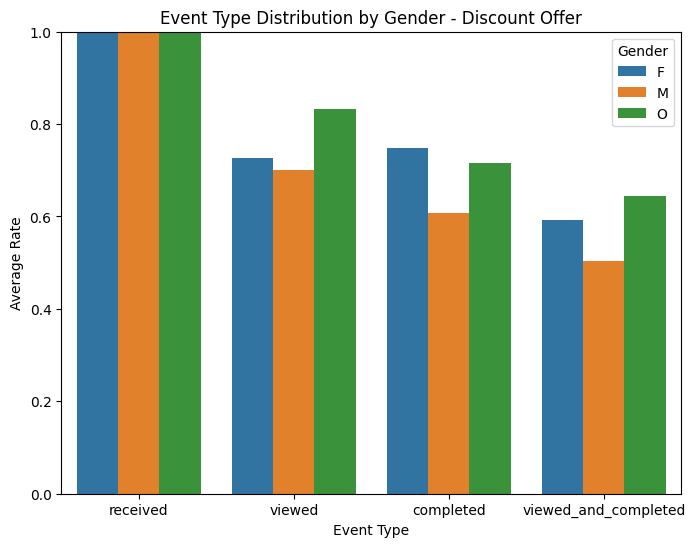

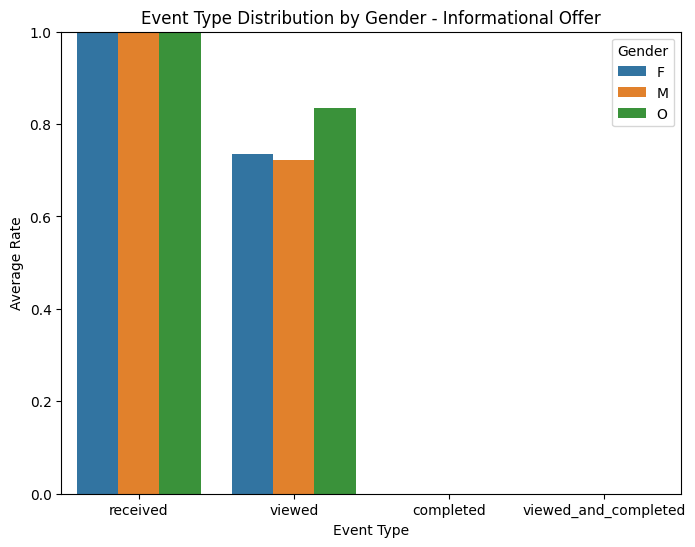

In [69]:
# Loop through each offer type
for offer in gender_event_plot['offer_type'].unique():
    subset = gender_event_plot[gender_event_plot['offer_type'] == offer]

    # Reshape: put event types on x-axis
    plot_df = pd.melt(
        subset,
        id_vars='gender',
        value_vars=['received', 'viewed', 'completed', 'viewed_and_completed'],
        var_name='event_type',
        value_name='rate'
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(data=plot_df, x='event_type', y='rate', hue='gender')
    plt.title(f'Event Type Distribution by Gender - {offer.capitalize()} Offer')
    plt.ylabel('Average Rate')
    plt.xlabel('Event Type')
    plt.ylim(0, 1)
    plt.legend(title='Gender')
    plt.show()

In [70]:
# Average response rates per income and offer_type
income_plot = offer_response.groupby(['income_bracket', 'offer_type'])[
    ['received', 'viewed', 'completed', 'viewed_and_completed']
].mean().reset_index()


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\985096088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_plot = offer_response.groupby(['income_bracket', 'offer_type'])[


C:\Users\cmezu\AppData\Local\Temp\ipykernel_24160\120938807.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_event_plot = offer_response.groupby(['income_bracket', 'offer_type'])[


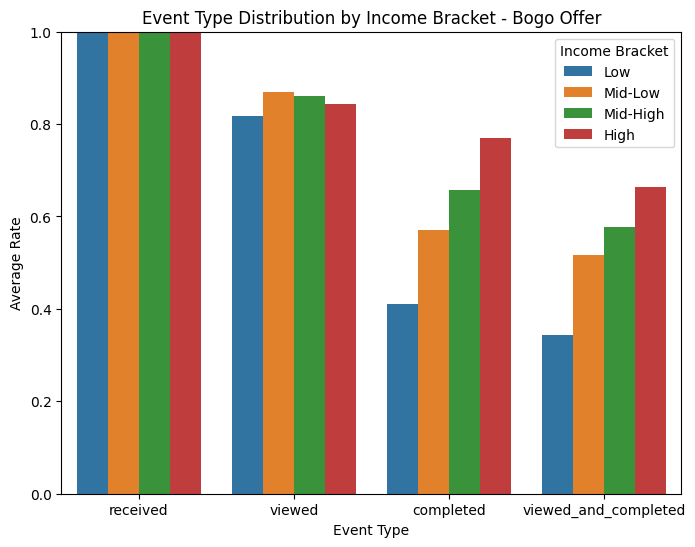

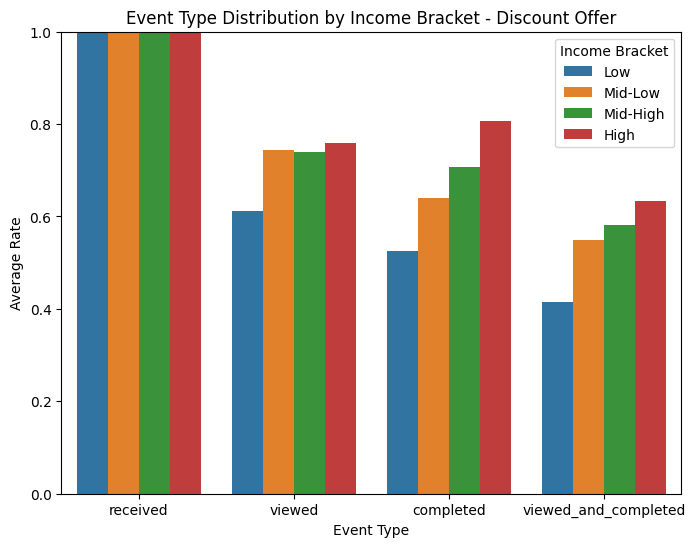

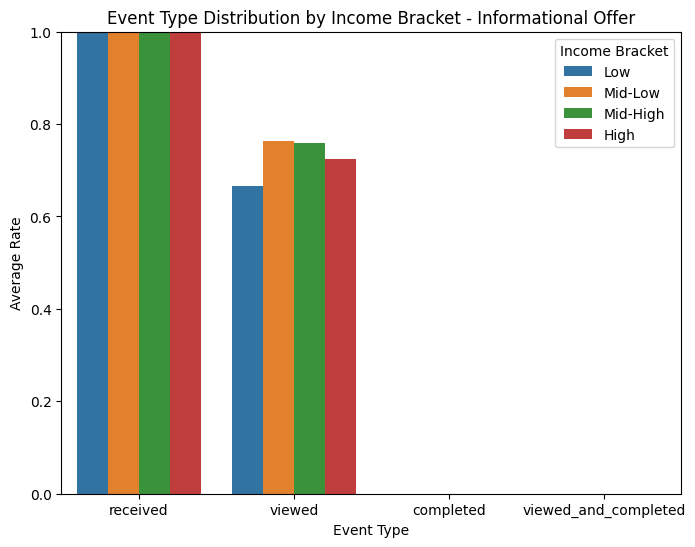

In [71]:
# Group by income_bracket and offer_type
income_event_plot = offer_response.groupby(['income_bracket', 'offer_type'])[
    ['received', 'viewed', 'completed', 'viewed_and_completed']
].mean().reset_index()

# Loop through each offer type
for offer in income_event_plot['offer_type'].unique():
    subset = income_event_plot[income_event_plot['offer_type'] == offer]

    # Reshape: put event types on x-axis
    plot_df = pd.melt(
        subset,
        id_vars='income_bracket',
        value_vars=['received', 'viewed', 'completed', 'viewed_and_completed'],
        var_name='event_type',
        value_name='rate'
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(data=plot_df, x='event_type', y='rate', hue='income_bracket')
    plt.title(f'Event Type Distribution by Income Bracket - {offer.capitalize()} Offer')
    plt.ylabel('Average Rate')
    plt.xlabel('Event Type')
    plt.ylim(0, 1)
    plt.legend(title='Income Bracket')
    plt.show()


Build a model


In [72]:
# Select features for modeling
features = ['offer_type', 'viewed', 'age_group', 'gender', 'income_bracket']
X = offer_response[features]
y = offer_response['viewed_and_completed']


In [73]:
# Convert categorical features to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

In [74]:
# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [75]:
# Train a Random Forest Classifier with class weighting to handle imbalance
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [76]:
# Predict
y_pred = model.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
styled_report = report_df[['precision', 'recall', 'f1-score', 'support']].round(2)

print("=== Classification Report ===")
display(styled_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=["Actual No Offer", "Actual Completed"],
                     columns=["Predicted: No", "Predicted: Yes"])

print("\n=== Confusion Matrix ===")
display(cm_df)

=== Classification Report ===


,precision,recall,f1-score,support
0,0.95,0.73,0.83,9517.00
1,0.72,0.95,0.82,7050.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.84,0.84,0.82,16567.00
weighted avg,0.85,0.82,0.82,16567.00



=== Confusion Matrix ===


,Predicted: No,Predicted: Yes
Actual No Offer,6944,2573
Actual Completed,362,6688


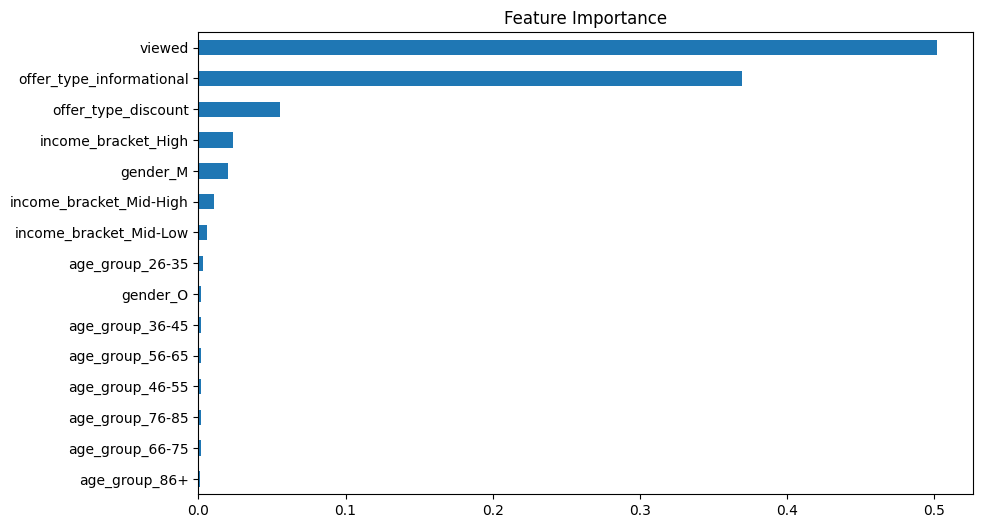

In [77]:
#feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10, 6), title='Feature Importance')
plt.show()

Alternative Model Results

In [78]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83      9517
           1       0.72      0.95      0.82      7050

    accuracy                           0.82     16567
   macro avg       0.84      0.84      0.82     16567
weighted avg       0.85      0.82      0.82     16567

